In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Corelli/Duke Spring 2022/AIPI 540/Recommendation Systems Module Project/data/final-data/final_dataframe.pkl"

In [ ]:
ratings = pd.read_pickle("/content/drive/MyDrive/Corelli/Duke Spring 2022/AIPI 540/Recommendation Systems Module Project/data/final-data/ratings_df.pkl")
business_df = pd.read_pickle("/content/drive/MyDrive/Corelli/Duke Spring 2022/AIPI 540/Recommendation Systems Module Project/data/final-data/business_df_clean.pkl")
csmatrix = pd.read_pickle("/content/drive/MyDrive/Corelli/Duke Spring 2022/AIPI 540/Recommendation Systems Module Project/data/final-data/csmatrix.pkl")

In [ ]:
unique_business_ids = ratings["business_id"].unique()
unique_business_ids

test_dict = {}

for i in range(len(unique_business_ids)):
    test_dict[unique_business_ids[i]] = i

In [ ]:
unique_user_ids = ratings["user_id"].unique()
unique_user_ids

user_id_dict = {}

for i in range(len(unique_user_ids)):
    user_id_dict[unique_user_ids[i]] = i

In [ ]:
ratings["user_id"] = ratings["user_id"].map(user_id_dict)
ratings["business_id"] = ratings["business_id"].map(test_dict)
ratings

,business_id,user_id,review_stars
0,0,0,5
1,0,1,5
2,0,2,3
3,1,3,1
4,1,4,4
...,...,...,...
856479,10862,44036,2
856480,10862,56094,5
856481,10862,88166,5
856482,10862,182915,5


In [ ]:
X = ratings[["user_id","business_id"]]
y = ratings["review_stars"]

X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

# Put data into PyTorch dataloaders

In [ ]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

# Define model architecture

In [ ]:
class NNColabFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, embedding_dim_users, embedding_dim_items, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim_items)
        self.fc1 = nn.Linear(embedding_dim_users+embedding_dim_items,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Concatenate user and item embeddings
        embeddings = torch.cat([embedded_users,embedded_items],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [ ]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X['user_id'].max()+1
n_items = X['business_id'].max()+1
model = NNColabFiltering(n_users,n_items,embedding_dim_users=50, embedding_dim_items=50, n_activations = 100,rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=6
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)

Epoch 0/5
----------
train loss: 1.3348
val loss: 1.2885
Epoch 1/5
----------
train loss: 1.2682
val loss: 1.2713
Epoch 2/5
----------
train loss: 1.2476
val loss: 1.2656
Epoch 3/5
----------
train loss: 1.2440
val loss: 1.2670
Epoch 4/5
----------
train loss: 1.2440
val loss: 1.2673
Epoch 5/5
----------
train loss: 1.2435
val loss: 1.2683
Training complete in 3m 45s


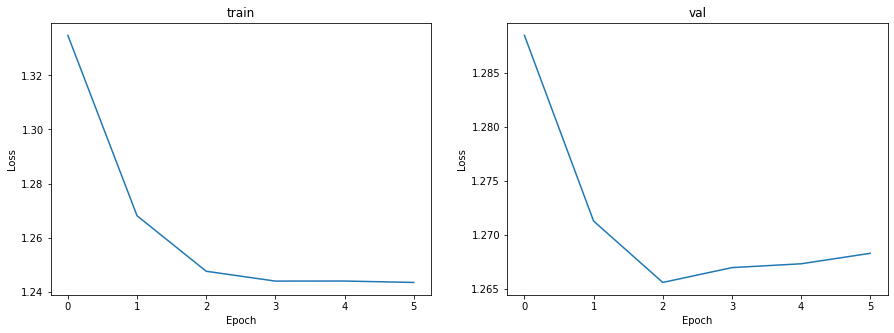

In [ ]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

In [ ]:
def predict_rating(model,user_id,business_id, device):
    # Get predicted rating for a specific user-item pair from model
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([user_id,business_id]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

# Get predicted rating for a random user-item pair
rating = predict_rating(model,4,10,device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))


Predicted rating is 4.1


# Final val RMSE of collab filtering: 1.2676

In [ ]:
def generate_recommendations(movies,X,model,userId,device,business_id_dict):
    # Get predicted ratings for every movie
    pred_ratings = []
    for movie in movies['business_id'].tolist():
        pred = predict_rating(model,userId,movie,device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = movies.iloc[idxs]['business_id'].values.tolist()
    # Filter out movies already watched by user
    movies_watched = X.loc[X['user_id']==userId, 'business_id'].tolist()
    recs = [rec for rec in recs if not rec in movies_watched]
    # Filter to top 10 recommendations
    recs = recs[:10]
    # Convert movieIDs to titles
    rec_nums = []
    rec_names = []
    total_stars = []
    total_reviews = []

    for rec in recs:
        rec_nums.append(movies.loc[movies['business_id']==rec,'business_id'].values[0])

    for i in range(10):
      rec_names.append(business_df[business_df["business_id"]==list(test_dict.keys())[list(test_dict.values()).index(rec_nums[i])]]["name"].values[0])
      total_stars.append(business_df[business_df["business_id"] == list(test_dict.keys())[list(test_dict.values()).index(rec_nums[i])]]["stars"].values[0])
      total_reviews.append(business_df[business_df["business_id"] == list(test_dict.keys())[list(test_dict.values()).index(rec_nums[i])]]["review_count"].values[0])
    
    return rec_names, total_stars, total_reviews

In [ ]:
# Get recommendations for a random user
userId = 5
#movies = pd.read_csv(os.path.join(datapath,'movies.csv'))
recs, stars, total_reviews = generate_recommendations(ratings.sample(50),X,model,userId,device,test_dict)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}, {} stars, {} total reviews'.format(i+1,rec,stars[i],total_reviews[i]))

Recommendation 1: The Mediterranean Chickpea, 5.0 stars, 188 total reviews
Recommendation 2: Hole In One Donut, 5.0 stars, 214 total reviews
Recommendation 3: German Knodle, 5.0 stars, 193 total reviews
Recommendation 4: Thai Star Sushi Bar, 4.5 stars, 224 total reviews
Recommendation 5: Tasty Thai, 4.5 stars, 124 total reviews
Recommendation 6: Copenhagen Cafe, 4.5 stars, 84 total reviews
Recommendation 7: The Revolution Ice Cream Co., 4.5 stars, 280 total reviews
Recommendation 8: Alvarez  Authentic Latin Food, 4.5 stars, 51 total reviews
Recommendation 9: Señor Taco, 4.5 stars, 435 total reviews
Recommendation 10: Juice Habit, 4.5 stars, 43 total reviews


In [ ]:
business_df[business_df["business_id"]==list(test_dict.keys())[list(test_dict.values()).index(2792)]]["name"].values[0]

"Mike's Pizza & Deli Station"

In [ ]:
test_dict

{'eEOYSgkmpB90uNA7lDOMRA': 0,
 '0bPLkL0QhhPO5kt1_EXmNQ': 1,
 '0qNpTGTcqPwOLi2hADx4Xw': 2,
 'uI9XODGY_2_ieTE6xJ0myw': 3,
 'JgpnXv_0XhV3SfbfB50nxw': 4,
 'KWA2qtdwVEkMpd5soSKaGA': 5,
 'pJfh3Ct8iL58NZa8ta-a5w': 6,
 'RK6-cJ9hj53RzOlCBmpT-g': 7,
 'vje0KIiE7vtpx7JzmBx5LQ': 8,
 '4dVrWc4Nhuw9apfk9BWEcA': 9,
 'zFvqulgAYOpSG2t1v8AZ-w': 10,
 'aNtKyc2rr-uK5cqzY9TVQQ': 11,
 'P10BsKUeoeCeVoK4BS2u0w': 12,
 '7Du9oW73YcYFmXdtU5aiSg': 13,
 'QjV4v7q_pt7tt3K1US7IHg': 14,
 'CtMEJxpVMlNzFpB4PtFjfA': 15,
 'ZU6NodDOWaabGkeNpOWdXw': 16,
 '8c0r7olQSYGcws0bTd3ikw': 17,
 'Ucl9Vo5lwrUmYbV8Dv8X5g': 18,
 'xbRbvXSAVZBEwaUUn3mzbg': 19,
 'VVvUBlc_WIEb8obKGq39dA': 20,
 'py5aKmlTB2NarfsfcOpHOQ': 21,
 'dJfkfBbJz7wi0RgW-ph_Eg': 22,
 'zVlhs7BVaouutt-rles-YA': 23,
 'SRexiuEsx1d9-dZVUsssQA': 24,
 'XwoXi0M66RU6Gouq-DSDHw': 25,
 '8YJtf5v76SIz-4udyF4YmA': 26,
 'iBRXLFWD7PeSYDbKsd_JTw': 27,
 'sUQ-OfJYSNfz-cimEjoaXQ': 28,
 'j9Kaj_6tSeXmVMYCgZithg': 29,
 'EIlFs8kybcG-l60GJjNUIA': 30,
 'z9wCTHYI2VZy9YIblwSsgg': 31,
 'Rz0KfP7YAZV_yQE8